In [1]:
#
# classifer notebook
#

# for Colab paths
# import sys
# sys.path.append('/content/')
#
#!nvidia-smi
#!nvidia-smi -q


import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Lambda, Compose
from LSTMLandmarkDataset import LSTMLandmarkDataset
from torch.utils.data.sampler import SubsetRandomSampler

torch.set_default_dtype(torch.float64)

#
# MODEL
#
# Should be 63 classes:
# Price B/S * 10                 -> 20
# QTY B/S * 10                   -> 20
# QTY B/S 10,20-100              -> 20
# Action Cancel, Market, Garbage ->  3
#                                -> 63



# Define LSTM model
class LSTMModel(torch.nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = torch.nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0.detach(), c0.detach()))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out
    
#
# PARAMS
#

batch_size = 12
hidden_size = 72
learning_rate = .01
num_epochs = 250
sequence_length = 30

#
# INITIAL DATA
#

# for directory load each file
# generate mapping of file -> class -> idx
# if available copy data to gpu (model set below)
# typically need model + tensors (label and value) moved over. 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transformations = Compose([
    Lambda(lambda x: torch.tensor(x.values).to(device))
])
target_transformations = Compose([
    Lambda(lambda x: torch.tensor(x).to(device))
])

dataset = LSTMLandmarkDataset("/home/jovyan/train/lstm_data",
                              "/home/jovyan/model",
                              sequence_length,
                              transform=transformations,
                              target_transform = target_transformations)


num_classes = dataset.num_class
input_size = dataset.input_size() #2 * (21 * 3) + 12 + 1 + 10 #149 + 1 label = 150

# Split train and test indices
num_samples = len(dataset)
indices = list(range(num_samples))
split = int(np.floor(0.2 * num_samples)) # 20% test set
np.random.shuffle(indices)
training_indices, validation_indices = indices[split:], indices[:split]

       
# remove subset as these now need to be grouped
train_sampler = SubsetRandomSampler(training_indices)
valid_sampler = SubsetRandomSampler(validation_indices)
    
train_dataloader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
valid_dataloader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)



#
# INIT MODELS, LOSS FN, GRAD
#

# Initialize model
model = LSTMModel(input_size, hidden_size, num_classes).to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


#
# TRAIN
#

running_loss_epoch = 0
for epoch in range(num_epochs):
    for batch_idx, (labels, landmarks) in enumerate(train_dataloader):  

        # forward pass
        outputs = model(landmarks)
        labels = labels.type(torch.LongTensor)
        loss = criterion(outputs, labels)
        
        # zero out accumulated gradients
        optimizer.zero_grad()
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        # NB: len(dataloader) is num of batches
        running_loss_epoch += loss.item()
        
        if ((epoch+1) % 10 == 0) and ((batch_idx+1) % len(train_dataloader) == 0):
            print ('Epoch [{}/{}], Loss per (random) batch: {:.4f}, Running Loss (per N epoch): {:.4f}' 
                   .format(epoch+1, num_epochs, loss.item(), running_loss_epoch))
            running_loss_epoch = 0

    

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch [10/250], Loss per (random) batch: 1.2759, Running Loss (per N epoch): 135.0637
Epoch [20/250], Loss per (random) batch: 0.4985, Running Loss (per N epoch): 89.4515
Epoch [30/250], Loss per (random) batch: 0.6739, Running Loss (per N epoch): 70.4720
Epoch [40/250], Loss per (random) batch: 0.1286, Running Loss (per N epoch): 50.6404
Epoch [50/250], Loss per (random) batch: 0.4724, Running Loss (per N epoch): 51.5623
Epoch [60/250], Loss per (random) batch: 0.2706, Running Loss (per N epoch): 47.5623
Epoch [70/250], Loss per (random) batch: 0.4067, Running Loss (per N epoch): 49.0814
Epoch [80/250], Loss per (random) batch: 0.6135, Running Loss (per N epoch): 46.0966
Epoch [90/250], Loss per (random) batch: 0.3775, Running Loss (per N epoch): 45.2217
Epoch [100/250], Loss per (random) batch: 0.1910, Running Loss (per N epoch): 43.4024
Epoch [110/250], Loss per (random) batch: 0.2637, Running Loss (per N epoch): 42.7486
Epoch [120/250], Loss per (random) batch: 0.1726, Running Loss

In [2]:
#
# EXPORT
#
# NB: LandmarkDataset.py updates meta.json with class index
#

dummy_input = torch.zeros(1, dataset.seq_len, input_size)
#model.load_state_dict(torch.load('./model_overfit.pt'))
torch.onnx.export(model, dummy_input, 'onnx_model_LSTM.onnx', export_params=True,
                  input_names = ['landmarks'], output_names = ['class'], verbose=True)

torch.save(model, "./model_LSTM.pt") 
#import onnx
#onnx_model = onnx.load("./onnx_model.onnx")
#onnx.checker.check_model(onnx_model)


Exported graph: graph(%landmarks : Double(1, 30, 150, strides=[4500, 150, 1], requires_grad=0, device=cpu),
      %fc.weight : Double(7, 72, strides=[72, 1], requires_grad=1, device=cpu),
      %fc.bias : Double(7, strides=[1], requires_grad=1, device=cpu),
      %onnx::LSTM_118 : Double(1, 288, 150, strides=[43200, 150, 1], requires_grad=0, device=cpu),
      %onnx::LSTM_119 : Double(1, 288, 72, strides=[20736, 72, 1], requires_grad=0, device=cpu),
      %onnx::LSTM_120 : Double(1, 576, strides=[576, 1], requires_grad=0, device=cpu),
      %onnx::Concat_121 : Long(1, strides=[1], requires_grad=0, device=cpu)):
  %onnx::Concat_122 : Long(1, strides=[1], requires_grad=0, device=cpu) = onnx::Identity[onnx_name="Identity_0"](%onnx::Concat_121)
  %onnx::Expand_7 : Double(1, 1, 72, strides=[72, 72, 1], requires_grad=0, device=cpu) = onnx::Constant[value=<Tensor>, onnx_name="Constant_1"]() # /tmp/ipykernel_4220/1800440718.py:45:0
  %onnx::Expand_8 : Double(1, 1, 72, strides=[72, 72, 1], requ

/opt/conda/lib/python3.10/site-packages/torch/onnx/symbolic_opset9.py:3227: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-p6uw8zvj because the default path (/home/jovyan/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


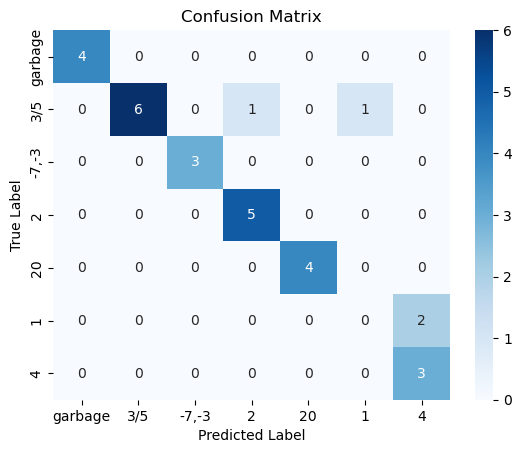

--------
Accuracy 25/29 : 0.8621
------------
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      0.75      0.86         8
           2       1.00      1.00      1.00         3
           3       0.83      1.00      0.91         5
           4       1.00      1.00      1.00         4
           5       0.00      0.00      0.00         2
           6       0.60      1.00      0.75         3

    accuracy                           0.86        29
   macro avg       0.78      0.82      0.79        29
weighted avg       0.86      0.86      0.85        29

------------


In [3]:
#
# EVAL / INFERENCE
#
torch.set_printoptions(precision=4, sci_mode=False)
softmax = torch.nn.Softmax(dim=1)
accuracy = 0
count = 0

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

y_test = []
y_pred = []

model.eval()
with torch.no_grad():
    
    matches = {}
    counts = {}
    
    for batch_idx, (labels, landmarks) in enumerate(valid_dataloader):  
        out = model(landmarks)
        prob = softmax(out.data)     #setup for threshold or 'garbage' class
        _, klass = torch.max(out.data, 1)

        # aggregate accuracy
        accuracy += (klass == labels).sum().item()
        count += len(labels)

        y_test = y_test + labels.tolist()
        y_pred = y_pred + klass.tolist()
    
    
    cm = confusion_matrix(y_test, y_pred)
    # qty +3, price +5  → 1
    # qty -7, price -3  → 2
    # qty 2             → 3
    # qty 20            → 4
    # price 1           → 5
    # price 4           → 6

    labels = ['garbage', '3/5', '-7,-3', '2', '20', '1', '4' ]
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
    #plt.title(f"{model name} Confusion Matrix")
    plt.title(f"Confusion Matrix")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()        

print('--------')
print("Accuracy {}/{} : {:.4f}".format(accuracy, count, accuracy/count))
print("------------")
print("Classification Report")
print( classification_report(y_test, y_pred) )
print("------------")

# class vs percentage label match - track whether some gestures have bad data
acc = sorted([(int(k), v / counts.get(k, 1)) for k,v in matches.items()], key=lambda x:x[1])
for klass, match in acc:
    print(klass, " {:.4f}".format(match))


In [4]:
print("DONE")

DONE
